In [1]:
import cebra
from cebra import CEBRA
import cebra.models
import os
from scipy import stats
import tempfile
from pathlib import Path
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import rgb2hex
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import sys
sys.path.append('../../../')
from dataset_load import data_load
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, f1_score, balanced_accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline
from collections import defaultdict
import seaborn as sns

In [2]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]

In [3]:
data_dict = data_load(input_folder, variables_to_drop, skipdates)#, dataset_name="neukin_dataset_baseline_w1500ms")

x = data_dict["X_pd"]
y = data_dict["y_pd"]

No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [4]:
def df_f1_score(true, pred, exclude_gait=False, average="weighted"):
    scores = []
    for t, p in zip(true, pred):
        if exclude_gait:
            p = p[np.where(t!=2, True, False)]
            t = t[np.where(t!=2, True, False)]
        scores.append(f1_score(t,p, average=average))
    return scores

def df_balanced_accuracy_score(true, pred):
    scores = []
    for t, p in zip(true, pred):
        scores.append(balanced_accuracy_score(t,p))
    return scores

In [14]:
permutations = {}
for i in range(11):
    with open(f"../kinematic_folds_cm/kinematic_predictions/predictions_kin_{i}_pd.pkl", "rb") as reference_file:
        permutations[i] = pkl.load(reference_file)

perms_df = pd.DataFrame.from_dict(permutations)
perms_df = perms_df.T
perms_df["f_score"] = df_f1_score(perms_df["true"], perms_df["prediction"], exclude_gait=False)
perms_df["f_score_no_gait"] = df_f1_score(perms_df["true"], perms_df["prediction"], exclude_gait=True)
perms_df['fold'] = perms_df.index

In [15]:
np.mean(perms_df["f_score"])

0.5978828078908532

In [16]:
scores_list = []
scores_ng_list = []


for i in range(11):
    with open(f"./fold_eval/permutations_fold_{i}_kin.pkl", "rb") as input_file:
        knn_results = pkl.load(input_file)
        scores_d = {}
        scores_ng = {}
        for key, val in knn_results.items():
            
            true = val["true"]
            prediction =  val["prediction"]
            score = f1_score(true, prediction, average="weighted")
            scores_d[key] = score
            
            
        #df = pd.DataFrame(data=zip(knn_results.keys(), scores, scores_ng), columns=["feats", "f_score", "f_score_no_gait"])
        df = pd.DataFrame(scores_d, index=[i])
        scores_list.append(df)


In [17]:
scores_df = pd.concat(scores_list)

In [18]:
df = pd.merge(scores_df, perms_df[["f_score"]], left_index=True,  right_index=True , suffixes=["", "_ref"])
df_delta = - df.sub(df["f_score"], axis=0)
df_delta = df_delta.drop("f_score", axis=1)
means_df = pd.DataFrame(df_delta.mean(axis=0), index=df_delta.columns)
means_df.to_csv("../../../../ML_analysis/LDA_neural/mean_delta_knn_f1_kin.csv")

In [19]:
ord_idxs = np.argsort(df_delta.mean(axis=0))[::-1]
ordered_feats = df_delta.columns[ord_idxs]

In [20]:
ordered_feats

Index(['rknee_speed_mean', 'rcrest_speed_mean', 'left_crest_angle_mean',
       'rshoulder_speed_mean', 'lknee_speed_mean', 'lshoulder_speed_mean',
       'lmtp_fwd_move', 'rmtp_fwd_move', 'right_knee_angular_velocity_mean',
       'trunk_cross_l_angular_velocity_mean',
       'left_knee_angular_velocity_mean', 'left_crest_angular_velocity_mean',
       'rmtp_speed_mean', 'trunk_cross_r_angular_velocity_mean',
       'left_knee_angle_mean', 'lankle_speed_mean', 'lmtp_height',
       'right_ankle_angular_velocity_mean', 'right_crest_angle_mean',
       'left_hip_angular_velocity_mean', 'left_ankle_angular_velocity_mean',
       'right_crest_angular_velocity_mean', 'lmtp_speed_mean',
       'trunk_cross_r_angle_mean', 'right_hip_angular_velocity_mean',
       'trunk_cross_l_angle_mean', 'left_hip_angle_mean', 'rankle_speed_mean',
       'left_ankle_angle_mean', 'right_ankle_angle_mean', 'lcrest_speed_mean',
       'right_hip_angle_mean', 'rhip_speed_mean', 'lhip_speed_mean',
       'righ

In [21]:
selected_feats = ordered_feats[:10]
selected_feats

Index(['rknee_speed_mean', 'rcrest_speed_mean', 'left_crest_angle_mean',
       'rshoulder_speed_mean', 'lknee_speed_mean', 'lshoulder_speed_mean',
       'lmtp_fwd_move', 'rmtp_fwd_move', 'right_knee_angular_velocity_mean',
       'trunk_cross_l_angular_velocity_mean'],
      dtype='object')

In [22]:
feats_n = 5
cmap = plt.get_cmap('twilight')
feats_cmap = cmap(np.linspace(0.1, 1, 6))[:feats_n]
cmap_d = {k : v for k, v in zip(ordered_feats[:feats_n], feats_cmap)}

[-0.05  -0.025  0.     0.025  0.05   0.075  0.1    0.125]


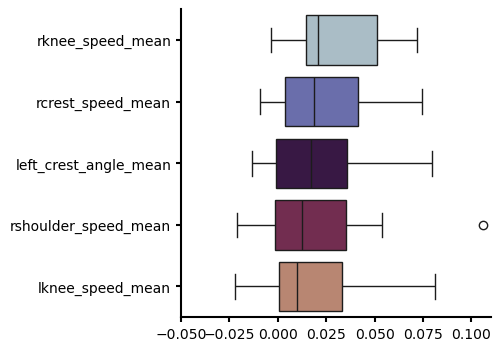

In [24]:
fig, ax = plt.subplots(figsize=(4,4))

selected_feats = ordered_feats[:feats_n]
sns.boxplot(data=df_delta[selected_feats], orient="h", order=selected_feats, palette= cmap_d)
#ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1])



#ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
#ax.set_yticks(ticks=ax.get_yticks(), labels=[], fontsize=15)


ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

ax.set_xlim(-0.05, 0.11)
print(ax.get_xticks())
#plt.savefig("./permutation_kinematics.svg", transparent=True)
#plt.savefig("./permutation_kinematics.png", transparent=True)

[-0.1  -0.05  0.    0.05  0.1   0.15]


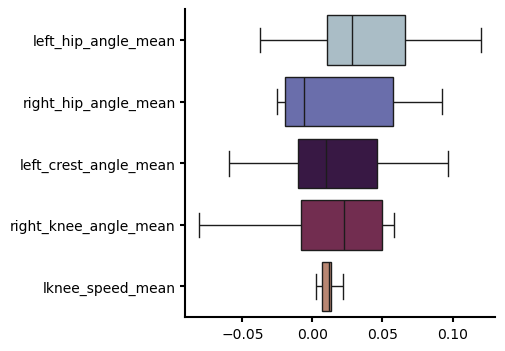

In [38]:
permutations = {}
for i in range(11):
    with open(f"../../CEBRA_train/new_run_fold/predictions_kin_pd/predictions_kin_{i}_pd.pkl", "rb") as reference_file:
        permutations[i] = pkl.load(reference_file)

perms_df = pd.DataFrame.from_dict(permutations)
perms_df = perms_df.T
perms_df["f_score"] = df_f1_score(perms_df["true"], perms_df["prediction"], exclude_gait=False, average=None)
perms_df["f_score"] =  df_balanced_accuracy_score(perms_df["true"], perms_df["prediction"])
#perms_df["f_score"] = perms_df["f_score"].apply(lambda x: x[2])
perms_df['fold'] = perms_df.index

scores_list = []

for i in range(11):
    with open(f"../../CEBRA_train/new_run_fold/knn_eval/fold_eval/permutations_fold_{i}_kin.pkl", "rb") as input_file:
        knn_results = pkl.load(input_file)
        scores_d = {}
        scores_ng = {}
        for key, val in knn_results.items():
            
            true = val["true"]
            prediction =  val["prediction"]
            #score = f1_score(true, prediction, average=None)[2]
            score = balanced_accuracy_score(true, prediction)
            scores_d[key] = score
            
        #df = pd.DataFrame(data=zip(knn_results.keys(), scores, scores_ng), columns=["feats", "f_score", "f_score_no_gait"])
        df = pd.DataFrame(scores_d, index=[i])
        scores_list.append(df)
scores_df = pd.concat(scores_list)
df = pd.merge(scores_df, perms_df[["f_score"]], left_index=True,  right_index=True , suffixes=["", "_ref"])
df_delta = - df.sub(df["f_score"], axis=0)
df_delta = df_delta.drop("f_score", axis=1)
ord_idxs = np.argsort(df_delta.mean(axis=0))[::-1]
ordered_feats = df_delta.columns[ord_idxs]
selected_feats = ordered_feats[:10]
feats_n = 5
cmap = plt.get_cmap('twilight')
feats_cmap = cmap(np.linspace(0.1, 1, 6))[:feats_n]
cmap_d = {k : v for k, v in zip(ordered_feats[:feats_n], feats_cmap)}


fig, ax = plt.subplots(figsize=(4,4))

selected_feats = ordered_feats[:feats_n]
sns.boxplot(data=df_delta[selected_feats], orient="h", order=selected_feats, palette= cmap_d)
#ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1])



#ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
#ax.set_yticks(ticks=ax.get_yticks(), labels=[], fontsize=15)
print(ax.get_xticks())
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)
plt.savefig("./permutation_kinematics_gait.svg", transparent=True)
#ax.set_xlim(-0.01, 0.14)

In [39]:
perms_df["f_score"].mean()

0.4887941072266491

In [40]:
perms_df["f_score"].std()

0.04454269486514857

In [41]:
perms_df

,true,prediction,score,f_score,fold
0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.073681,0.489445,0
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...",-0.099605,0.493821,1
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",-0.031426,0.455883,2
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",-0.381718,0.530417,3
4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",-0.018941,0.504904,4
5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",-0.632192,0.454674,5
6,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",-1.275932,0.440241,6
7,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.429237,0.415522,7
8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",-0.768923,0.571305,8
9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",-0.615537,0.517991,9


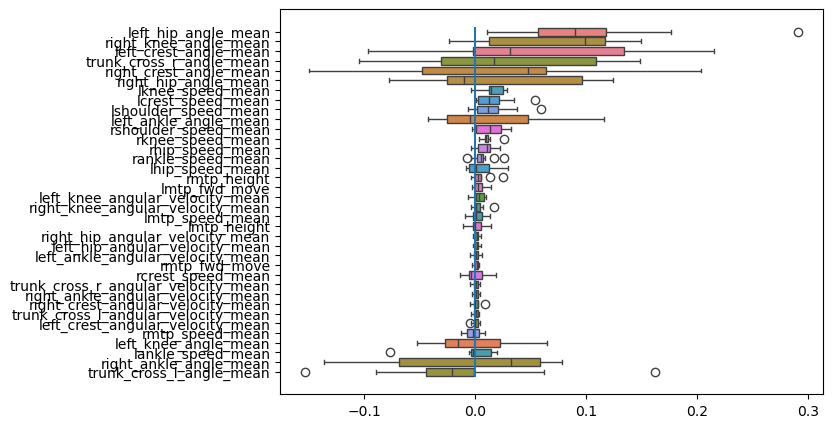

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df_delta, orient="h", order=ordered_feats)
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1])

NameError: name 'spearmanr' is not defined

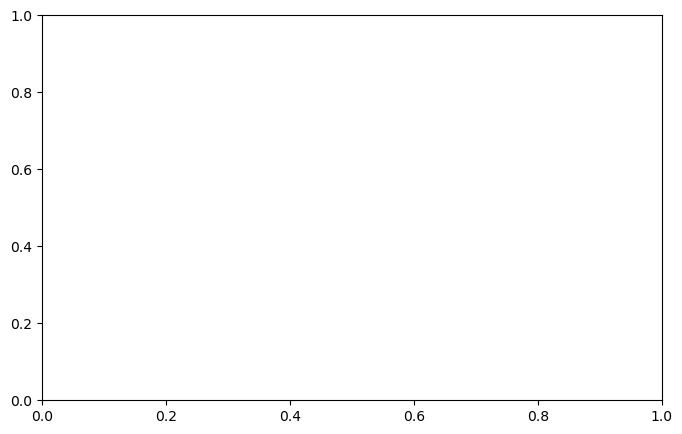

In [22]:
x = x.iloc[:, :36]
fig, ax1 = plt.subplots(figsize=(8, 5))
corr = spearmanr(x).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=x.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
_ = fig.tight_layout()

In [ ]:
selected_features

In [ ]:

fig, ax2 = plt.subplots(figsize=(8, 8))
corr = spearmanr(x).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()
plt.savefig("./corr_kin.png")

In [ ]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features = x.columns[selected_features]

In [ ]:
selected_features

In [ ]:
cluster_id_to_feature_ids

In [ ]:
cluster_ids